# eICU Database Exploration

This notebook explores the eICU-CRD database structure and content.

**Objective:** Understand the database schema, table relationships, and data quality for federated learning experiments.

In [1]:
import duckdb
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Matplotlib settings
plt.style.use('default')
%matplotlib inline

## Connect to Database

In [2]:
# Connect to DuckDB database
db_path = '../../data/duckdb/fedlearn.duckdb'
conn = duckdb.connect(db_path, read_only=True)

print(f"Connected to: {db_path}")

Connected to: ../../data/duckdb/fedlearn.duckdb


## Database Schema Overview

In [3]:
# List all tables
tables = conn.execute("SHOW TABLES").fetchdf()
print(f"Number of tables: {len(tables)}")
print("\nAvailable tables:")
tables

Number of tables: 31

Available tables:


,name
0,NURSEASSESSMENT
1,NURSECARE
2,NURSECHARTING
3,RESPIRATORYCARE
4,RESPIRATORYCHARTING
5,admissiondrug
6,admissiondx
7,allergy
8,apacheapsvar
9,apachepatientresult


In [4]:
# Get row counts for each table
def get_table_stats(conn, table_name):
    count = conn.execute(f"SELECT COUNT(*) as count FROM {table_name}").fetchone()[0]
    return count

table_stats = []
for table in tables['name']:
    count = get_table_stats(conn, table)
    table_stats.append({'table': table, 'row_count': count})

stats_df = pd.DataFrame(table_stats).sort_values('row_count', ascending=False)
stats_df

,table,row_count
2,NURSECHARTING,151604232
30,vitalperiodic,146671642
21,lab,39132531
29,vitalaperiodic,25075074
4,RESPIRATORYCHARTING,20168176
0,NURSEASSESSMENT,15602498
20,intakeoutput,12030289
27,physicalexam,9212316
1,NURSECARE,8311132
22,medication,7301853


## Explore Patient Table

In [5]:
# Check if patient table exists (or similar)
# Adjust table name based on what you see above
patient_query = """
SELECT * FROM patient 
LIMIT 5
"""

try:
    patients_sample = conn.execute(patient_query).fetchdf()
    print("Patient table sample:")
    display(patients_sample)
    
    print("\nColumn data types:")
    print(patients_sample.dtypes)
except Exception as e:
    print(f"Error: {e}")
    print("Adjust table name based on SHOW TABLES output above")

Patient table sample:


,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,0,Direct Admit,2015,03:50:00,3596,Death,Expired,Med-Surg ICU,15:54:00,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
1,141178,128927,Female,52,Caucasian,60,83,None,162.6,08:56:00,-14,Emergency Department,2015,19:20:00,2050,Home,Alive,Med-Surg ICU,09:10:00,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870
2,141179,128927,Female,52,Caucasian,60,83,None,162.6,08:56:00,-22,Emergency Department,2015,19:20:00,2042,Home,Alive,Med-Surg ICU,09:18:00,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,-780,Floor,2015,23:30:00,12492,Home,Alive,CTICU,07:18:00,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
4,141196,128943,Male,71,Caucasian,67,109,None,162.6,20:21:00,-99,Emergency Department,2015,17:00:00,5460,Home,Alive,Med-Surg ICU,22:00:00,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665



Column data types:
patientunitstayid              int32
patienthealthsystemstayid      int32
gender                        object
age                           object
ethnicity                     object
hospitalid                     int32
wardid                         int32
apacheadmissiondx             object
admissionheight              float64
hospitaladmittime24           object
hospitaladmitoffset            int32
hospitaladmitsource           object
hospitaldischargeyear          int16
hospitaldischargetime24       object
hospitaldischargeoffset        int32
hospitaldischargelocation     object
hospitaldischargestatus       object
unittype                      object
unitadmittime24               object
unitadmitsource               object
unitvisitnumber                int32
unitstaytype                  object
admissionweight              float64
dischargeweight              float64
unitdischargetime24           object
unitdischargeoffset            int32
unitdischargelocat

## Data Quality: Missing Values

Analyze null values in the patient table to understand data completeness.

Total records in patient table: 200,859
Total columns: 29

MISSING VALUE ANALYSIS
                   column  null_count  null_percentage  non_null_count data_type
          dischargeweight       90937            45.27          109922   float64
      hospitaladmitsource       49464            24.63          151395    object
        apacheadmissiondx       22996            11.45          177863    object
          admissionweight       16718             8.32          184141   float64
          admissionheight        4215             2.10          196644   float64
                ethnicity        2290             1.14          198569    object
hospitaldischargelocation        2033             1.01          198826    object
  hospitaldischargestatus        1751             0.87          199108    object
          unitadmitsource        1090             0.54          199769    object
    unitdischargelocation         334             0.17          200525    object
                   gender  

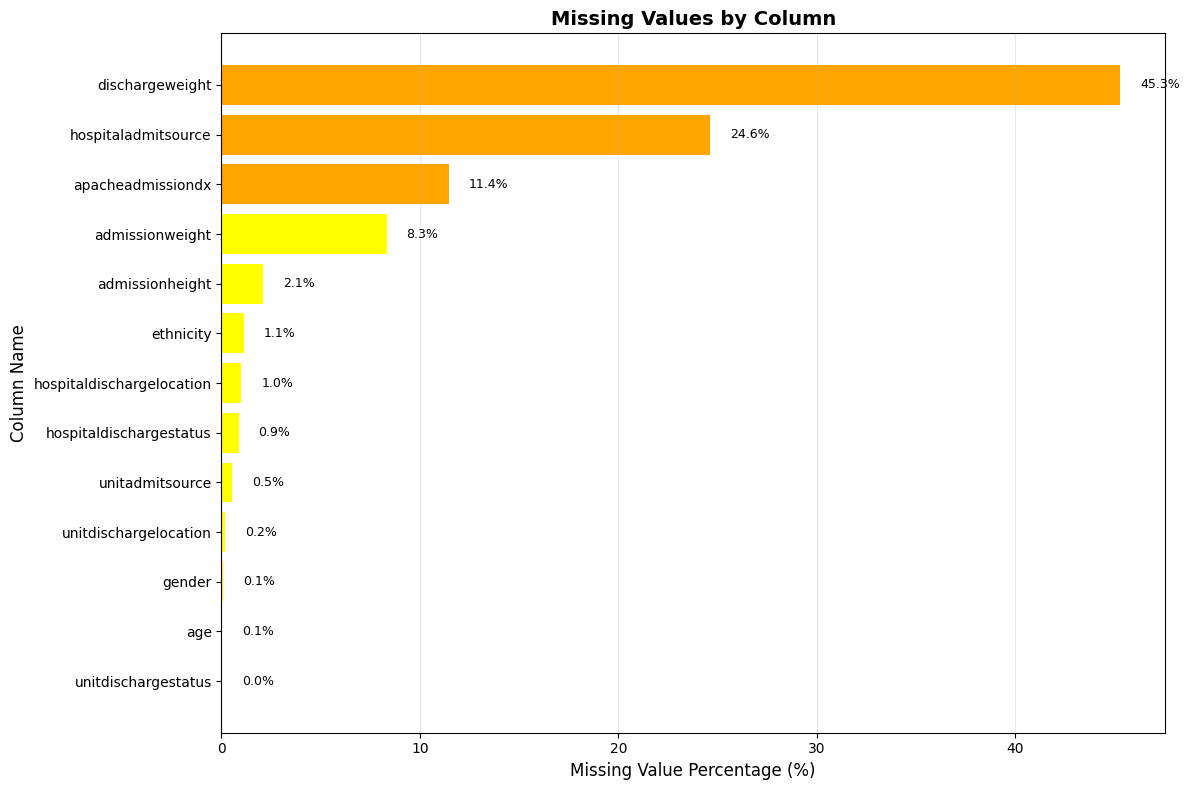

In [6]:
# Query to get all patient data for null analysis
null_check_query = """
SELECT * FROM patient
"""

df_patient = conn.execute(null_check_query).fetchdf()

print(f"Total records in patient table: {len(df_patient):,}")
print(f"Total columns: {len(df_patient.columns)}")

# Calculate missing values for each column
missing_data = pd.DataFrame({
    'column': df_patient.columns,
    'null_count': df_patient.isnull().sum(),
    'null_percentage': (df_patient.isnull().sum() / len(df_patient) * 100).round(2),
    'non_null_count': df_patient.notnull().sum(),
    'data_type': df_patient.dtypes
})

# Sort by null percentage descending
missing_data = missing_data.sort_values('null_percentage', ascending=False)

print("\n" + "=" * 80)
print("MISSING VALUE ANALYSIS")
print("=" * 80)
print(missing_data.to_string(index=False))

# Show only columns with missing values
print("\n" + "=" * 80)
print("COLUMNS WITH MISSING VALUES (> 0%)")
print("=" * 80)
missing_only = missing_data[missing_data['null_percentage'] > 0]
print(missing_only.to_string(index=False))

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Columns with no missing values: {len(missing_data[missing_data['null_percentage'] == 0])}")
print(f"Columns with missing values: {len(missing_data[missing_data['null_percentage'] > 0])}")
print(f"Columns with >50% missing: {len(missing_data[missing_data['null_percentage'] > 50])}")
print(f"Columns with >90% missing: {len(missing_data[missing_data['null_percentage'] > 90])}")

# Visualize missing data for columns with >0% missing
import matplotlib.pyplot as plt

if len(missing_only) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Sort for better visualization
    missing_plot = missing_only.sort_values('null_percentage')
    
    colors = ['red' if x > 50 else 'orange' if x > 10 else 'yellow' for x in missing_plot['null_percentage']]
    
    ax.barh(missing_plot['column'], missing_plot['null_percentage'], color=colors)
    ax.set_xlabel('Missing Value Percentage (%)', fontsize=12)
    ax.set_ylabel('Column Name', fontsize=12)
    ax.set_title('Missing Values by Column', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (col, pct) in enumerate(zip(missing_plot['column'], missing_plot['null_percentage'])):
        ax.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values found in any column!")

## Summary Statistics

In [7]:
# Get comprehensive patient statistics
patient_stats_query = """
SELECT 
    COUNT(DISTINCT patientunitstayid) as total_icu_stays,
    COUNT(DISTINCT patienthealthsystemstayid) as total_hospital_stays,
    COUNT(DISTINCT uniquepid) as unique_patients,
    COUNT(DISTINCT hospitalid) as num_hospitals
FROM patient
"""

stats = conn.execute(patient_stats_query).fetchdf()
print("Overall Database Statistics")
print("=" * 60)
for col in stats.columns:
    print(f"{col}: {stats[col].iloc[0]:,}")

# Gender distribution
print("\n\nGender Distribution")
print("=" * 60)
gender_query = """
SELECT gender, COUNT(*) as count
FROM patient
GROUP BY gender
ORDER BY count DESC
"""
gender_dist = conn.execute(gender_query).fetchdf()
gender_dist['percentage'] = (gender_dist['count'] / gender_dist['count'].sum() * 100).round(2)
print(gender_dist.to_string(index=False))

# Age distribution (top values)
print("\n\nAge Distribution (Top 15)")
print("=" * 60)
age_query = """
SELECT age, COUNT(*) as count
FROM patient
GROUP BY age
ORDER BY count DESC
LIMIT 15
"""
age_dist = conn.execute(age_query).fetchdf()
age_dist['percentage'] = (age_dist['count'] / age_dist['count'].sum() * 100).round(2)
print(age_dist.to_string(index=False))

# Ethnicity distribution
print("\n\nEthnicity Distribution")
print("=" * 60)
ethnicity_query = """
SELECT ethnicity, COUNT(*) as count
FROM patient
WHERE ethnicity IS NOT NULL
GROUP BY ethnicity
ORDER BY count DESC
"""
ethnicity_dist = conn.execute(ethnicity_query).fetchdf()
ethnicity_dist['percentage'] = (ethnicity_dist['count'] / ethnicity_dist['count'].sum() * 100).round(2)
print(ethnicity_dist.to_string(index=False))

# Hospital distribution (important for federated learning!)
print("\n\nPatients by Hospital (Top 20)")
print("=" * 60)
print("NOTE: This distribution is critical for federated learning client assignment")
hospital_query = """
SELECT 
    hospitalid,
    COUNT(DISTINCT patientunitstayid) as icu_stays,
    COUNT(DISTINCT uniquepid) as unique_patients
FROM patient
GROUP BY hospitalid
ORDER BY icu_stays DESC
LIMIT 20
"""
hospital_dist = conn.execute(hospital_query).fetchdf()
hospital_dist['percentage'] = (hospital_dist['icu_stays'] / hospital_dist['icu_stays'].sum() * 100).round(2)
print(hospital_dist.to_string(index=False))

# Unit type distribution
print("\n\nICU Unit Type Distribution")
print("=" * 60)
unit_query = """
SELECT unittype, COUNT(*) as count
FROM patient
GROUP BY unittype
ORDER BY count DESC
"""
unit_dist = conn.execute(unit_query).fetchdf()
unit_dist['percentage'] = (unit_dist['count'] / unit_dist['count'].sum() * 100).round(2)
print(unit_dist.to_string(index=False))

# Admission source
print("\n\nICU Admission Source")
print("=" * 60)
admit_query = """
SELECT unitadmitsource, COUNT(*) as count
FROM patient
WHERE unitadmitsource IS NOT NULL
GROUP BY unitadmitsource
ORDER BY count DESC
LIMIT 10
"""
admit_dist = conn.execute(admit_query).fetchdf()
admit_dist['percentage'] = (admit_dist['count'] / admit_dist['count'].sum() * 100).round(2)
print(admit_dist.to_string(index=False))

# Discharge status
print("\n\nICU Discharge Status")
print("=" * 60)
discharge_query = """
SELECT unitdischargestatus, COUNT(*) as count
FROM patient
WHERE unitdischargestatus IS NOT NULL
GROUP BY unitdischargestatus
ORDER BY count DESC
"""
discharge_dist = conn.execute(discharge_query).fetchdf()
discharge_dist['percentage'] = (discharge_dist['count'] / discharge_dist['count'].sum() * 100).round(2)
print(discharge_dist.to_string(index=False))

# Length of stay statistics
print("\n\nICU Length of Stay Statistics (in days)")
print("=" * 60)
los_query = """
SELECT 
    COUNT(*) as total_stays,
    MIN(unitdischargeoffset / (60.0 * 24)) as min_days,
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY unitdischargeoffset / (60.0 * 24)) as q1_days,
    PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY unitdischargeoffset / (60.0 * 24)) as median_days,
    AVG(unitdischargeoffset / (60.0 * 24)) as mean_days,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY unitdischargeoffset / (60.0 * 24)) as q3_days,
    PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY unitdischargeoffset / (60.0 * 24)) as p95_days,
    MAX(unitdischargeoffset / (60.0 * 24)) as max_days
FROM patient
WHERE unitdischargeoffset IS NOT NULL 
    AND unitdischargeoffset > 0
"""
los_stats = conn.execute(los_query).fetchdf()
print(los_stats.T.to_string(header=False))

Overall Database Statistics
total_icu_stays: 200,859
total_hospital_stays: 166,355
unique_patients: 139,367
num_hospitals: 208


Gender Distribution
 gender  count  percentage
   Male 108379       53.96
 Female  92303       45.95
   None    134        0.07
Unknown     35        0.02
  Other      8        0.00


Age Distribution (Top 15)
 age  count  percentage
> 89   7081       10.01
  67   5078        7.18
  68   4826        6.82
  72   4804        6.79
  71   4764        6.74
  66   4677        6.61
  65   4649        6.57
  70   4571        6.46
  63   4460        6.31
  62   4355        6.16
  73   4333        6.13
  64   4318        6.11
  69   4301        6.08
  75   4280        6.05
  60   4217        5.96


Ethnicity Distribution
       ethnicity  count  percentage
       Caucasian 155285       78.20
African American  21308       10.73
   Other/Unknown   9542        4.81
        Hispanic   7464        3.76
           Asian   3270        1.65
 Native American   1700        0.86


## Next Steps

**Completed in this notebook:**  
✅ Database schema overview  
✅ Table row counts  
✅ Patient table exploration  
✅ Missing value analysis  
✅ Summary statistics (demographics, hospital distribution, ICU types)  

**Next notebooks:**
1. ICU length of stay analysis (define prediction threshold)
2. Feature exploration and correlation analysis
3. Baseline model development with partial fitting
4. Federated learning implementation

In [8]:
# Close connection when done
conn.close()